In [1]:
# Assuming that you saved the original data with labels 'A', 'B', and 'C'
import numpy as np

def mat_min(linc):
    data = np.load(linc)
    r = data['nrows'][0]
    c = data['ncols'][0]

    print(data)
    print(r)
    print(c)

    if (r != c):
        print("Shape errore")
        return 0

    values = data['values']
    col_indices = data['col_indices']
    row_ptr = data['row_ptr']
    

    print(values)
    print(col_indices)
    print(row_ptr)

    X = np.zeros((r, c), dtype='float64')

    for i, i_pos in enumerate(row_ptr[:-2]):
        for j in range(i, i+i_pos):
            # print(i, j)
            X[i, col_indices[j]] = values[j]

    return X

X = mat_min('Тест_единичный/f_000050.npz')

def check(f, b, c, r):
    if np.shape(f) == np.shape(b) and np.shape(f) == np.shape(c) and np.shape(f)[0] == len(r):
        return False
    return True

def create_A_r(linc_f, linc_b, linc_c, linc_r):
    print(linc_f)
    f = mat_min(linc_f)
    print(linc_b)
    b = mat_min(linc_b)
    print(linc_c)
    c = mat_min(linc_c)
    r = mat_min(linc_r)
    i = np.identity(len(r))
    o = np.ones(len(r))
    
    if check(f, b, c, r): 
        print('shape: error')
        return 0
    
    f = np.concatenate((f, i), axis=1)
    c = np.concatenate((c, b), axis=1)
    f = np.concatenate((f, c), axis=0)

    r = np.concatenate((o, r))

    return f, r

def call_full_A_r(linc):
    txt_1 = 'Тест_единичный/'
    txt_2 = linc+'.npz'

    return txt_1 + 'f_' + txt_2, txt_1 + 'b_' + txt_2, txt_1 + 'c_' + txt_2, txt_1 + 'r_' + txt_2

def take_A_r(linc):
    a, b, c, r = call_full_A_r(linc)
    return create_A_r(a, b, c, r)

# print(call_full_A_r('abv'))
print(take_A_r('000050'))

NpzFile 'Тест_единичный/f_000050.npz' with keys: nrows, ncols, values, row_ptr, col_indices
82
82
[-5497.53681036   856.18106575   266.76441205 ...    90.07179977
  -850.87545342 -5867.52721925]
[ 0  1  2 ... 79 80 81]
[   0   20   41   63   86  110  134  159  185  213  242  272  303  335
  368  402  437  473  510  548  587  626  665  704  743  784  827  873
  920  972 1027 1085 1146 1208 1271 1334 1397 1460 1523 1586 1648 1709
 1769 1828 1886 1943 1999 2054 2108 2160 2213 2266 2317 2368 2420 2472
 2522 2573 2624 2675 2724 2774 2824 2874 2922 2971 3020 3069 3116 3164
 3212 3260 3306 3352 3399 3446 3491 3536 3582 3628 3672 3717 3762]
Тест_единичный/f_000050.npz
NpzFile 'Тест_единичный/f_000050.npz' with keys: nrows, ncols, values, row_ptr, col_indices
82
82
[-5497.53681036   856.18106575   266.76441205 ...    90.07179977
  -850.87545342 -5867.52721925]
[ 0  1  2 ... 79 80 81]
[   0   20   41   63   86  110  134  159  185  213  242  272  303  335
  368  402  437  473  510  548  587  626 

IndexError: index 382 is out of bounds for axis 0 with size 382

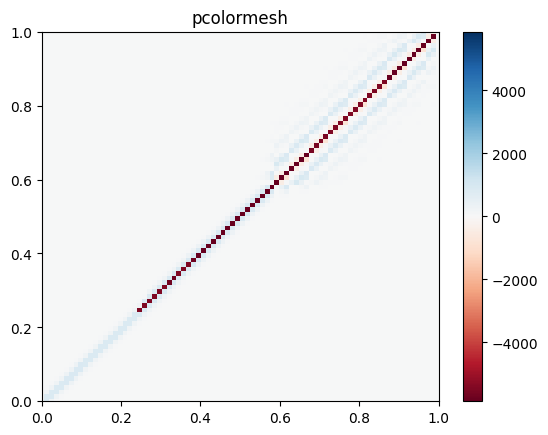

In [8]:
import matplotlib.pyplot as plt

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(0, 1, len(X[0])), np.linspace(0, 1, len(X)))

z_min, z_max = -np.abs(X).max(), np.abs(X).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, X, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
import os
from os import listdir
from os.path import isfile, join, dirname, basename
import re
import numpy as np
from scipy.sparse import csr_matrix, identity, vstack, hstack 
from scipy.sparse.linalg import spsolve
from time import perf_counter
import subprocess
import pandas as pd
from datetime import datetime
import sys
from pathlib import Path

# загрузка одной CSR матрицы 
def load_matrix(fpath):
    data = np.load(fpath)
    nr = int(data['nrows'][0])
    nc = int(data['ncols'][0])
    return csr_matrix((data['values'], data['col_indices'], data['row_ptr']), 
                             shape=(nr, nc))

# загрузка блочной матрицы 
def load_block_matrix_and_rhs(f_path, c_path, b_path, rhs_path):
    # F часть
    f_csr = load_matrix(f_path)
    # C часть
    c_csr = load_matrix(c_path)
    # B часть
    b_csr = load_matrix(b_path)
    # правая часть
    data = np.load(rhs_path)
    r_vec = data['rhs']
    return f_csr, c_csr, b_csr, r_vec

# загрузка блочной матрицы 
def load_system(f_path, c_path, b_path, rhs_path):
    # F block
    f_csr = load_matrix(f_path)
    # C block
    c_csr = load_matrix(c_path)
    # B block
    b_csr = load_matrix(b_path)
    # Right hand side
    data = np.load(rhs_path)
    r_vec = data['rhs']

    # block shape
    nr, nc = f_csr.shape
    
    # identity matrix
    e_mat = identity(nr, format='csr', dtype = f_csr.dtype)
    
    # build full matrix
    full_csr = vstack((hstack((f_csr, e_mat), format='csr'), 
                    hstack((c_csr, b_csr), format='csr')), format='csr')
    # full matrix size
    n = nr * 2
    
    full_rhs = np.zeros(n, dtype=f_csr.dtype)
    full_rhs[nr:] = r_vec[:]

    return full_csr, full_rhs


def take_your_matrix(txt):
    head = ['Тест_единичный/f_', 'Тест_единичный/c_', 'Тест_единичный/b_', 'Тест_единичный/r_']
    tail = '.npz'
    body = f'{txt:06}'


    full = []
    for i, l in enumerate(head):
        full.append(l+body+tail)

    print(full)

    A, b = load_system(full[0], full[1], full[2], full[3])

    return A, b

take_your_matrix(1590)

# A, b = load_system('Тест_единичный/f_004700.npz', 'Тест_единичный/c_004700.npz', 'Тест_единичный/b_004700.npz', 'Тест_единичный/r_004700.npz')
# A, b = load_system('Тест_единичный/f_000050.npz', 'Тест_единичный/c_000050.npz', 'Тест_единичный/b_000050.npz', 'Тест_единичный/r_000050.npz')

# A = np.array(A.toarray())

# b = np.array(b)

# x = np.linalg.solve(A, b)  
# print("Решение системы (x, y):")  
# print(x)  

# print(np.linalg.norm(A*x - b))

# from scipy import linalg
# x = linalg.solve(A, b)
# x = spsolve(A, b)


# print(np.linalg.norm(A*x - b))


take_your_matrix(1590)

['Тест_единичный/f_001590.npz', 'Тест_единичный/c_001590.npz', 'Тест_единичный/b_001590.npz', 'Тест_единичный/r_001590.npz']


(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 2016736 stored elements and shape (8012, 8012)>,
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.75078806e-11, -1.76067516e-11,  4.18088889e-12], shape=(8012,)))

In [4]:
x = 100
print(f'{x:05}')

00100


C:\Users\ddigo\AppData\Local\Temp\ipykernel_26424\258229768.py:6: RuntimeWarning: divide by zero encountered in log
  z_min, z_max = -np.log(np.abs(A)).max(), np.log(np.abs(A)).max()
C:\Users\ddigo\AppData\Local\Temp\ipykernel_26424\258229768.py:10: RuntimeWarning: divide by zero encountered in log
  c = ax.pcolormesh(x, y, np.log(np.abs(A)), cmap='RdBu', vmin=z_min, vmax=z_max)


MemoryError: Unable to allocate 447. MiB for an array with shape (21660, 21660) and data type bool

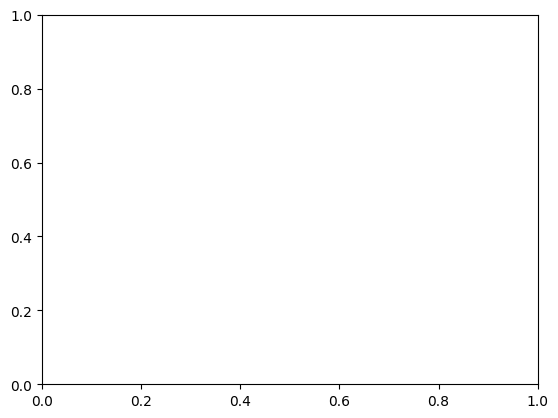

In [5]:
import matplotlib.pyplot as plt

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(0, -1, len(A[0])), np.linspace(0, 1, len(A)))

z_min, z_max = -np.log(np.abs(A)).max(), np.log(np.abs(A)).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, np.log(np.abs(A)), cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('50')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

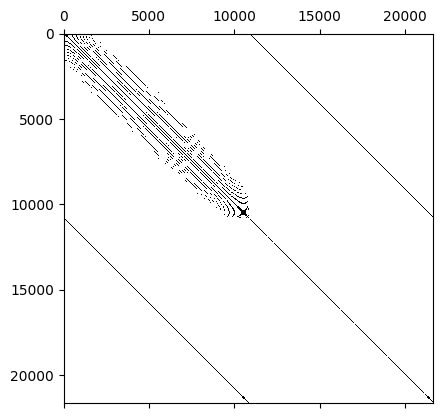

In [4]:
import matplotlib.pyplot as plt
plt.spy(A)

In [25]:
np.linalg.eigh(A)

EighResult(eigenvalues=array([-9.09406306e+03, -8.94715497e+03, -8.56138618e+03, -8.14446513e+03,
       -7.83120740e+03, -7.65620394e+03, -7.52791937e+03, -7.32690820e+03,
       -7.23163354e+03, -7.21147847e+03, -7.17560105e+03, -7.12165486e+03,
       -7.06928634e+03, -7.04920820e+03, -6.97209056e+03, -6.92507049e+03,
       -6.92026218e+03, -6.83137806e+03, -6.78771940e+03, -6.77475346e+03,
       -6.75744679e+03, -6.73571490e+03, -6.72339348e+03, -6.69765770e+03,
       -6.66810253e+03, -6.63572398e+03, -6.59704264e+03, -6.54733883e+03,
       -6.49871136e+03, -6.44404088e+03, -6.41386693e+03, -6.37512085e+03,
       -6.31717603e+03, -6.24601769e+03, -6.21217815e+03, -6.16186096e+03,
       -6.08861197e+03, -6.05808230e+03, -5.99065150e+03, -5.92111453e+03,
       -5.86428957e+03, -5.84496824e+03, -5.76921675e+03, -5.66653335e+03,
       -5.57020218e+03, -5.47775131e+03, -5.43214083e+03, -5.33433537e+03,
       -5.29914210e+03, -5.22089201e+03, -5.10314085e+03, -5.06685932e+03,
  

In [26]:
from scipy.sparse.linalg import eigs

eigs(A, 1)

(array([-8883.5895994+0.j]),
 array([[ 6.96792182e-13+0.j],
        [ 1.49459339e-12+0.j],
        [ 2.31785650e-13+0.j],
        [-5.87907638e-12+0.j],
        [ 3.24886847e-11+0.j],
        [ 1.04063486e-10+0.j],
        [-2.36648379e-10+0.j],
        [ 1.14944968e-10+0.j],
        [ 3.45957524e-10+0.j],
        [-1.50451415e-09+0.j],
        [ 2.00319281e-09+0.j],
        [-2.04290688e-09+0.j],
        [-3.07202403e-10+0.j],
        [ 1.04938117e-09+0.j],
        [-1.60603814e-09+0.j],
        [ 1.70852079e-09+0.j],
        [-2.82908609e-09+0.j],
        [-1.40137959e-10+0.j],
        [-1.84314076e-09+0.j],
        [-3.32565098e-09+0.j],
        [-5.79947350e-09+0.j],
        [ 3.34337841e-09+0.j],
        [-4.23241304e-08+0.j],
        [-3.87816929e-07+0.j],
        [ 2.01581630e-06+0.j],
        [-2.19336400e-06+0.j],
        [ 2.57921190e-06+0.j],
        [-3.46280155e-06+0.j],
        [ 1.38526595e-05+0.j],
        [-2.80929768e-05+0.j],
        [ 3.50876070e-05+0.j],
        [-

In [28]:
import numpy as np
from tqdm.notebook import tqdm
import scipy.linalg

def precondition_by_upper(A):
    """
    Предобуславливает матрицу её верхней треугольной частью.
    
    Возвращает матрицу C = M^{-1} * A, где M — верхняя треугольная часть A (включая диагональ).
    
    Параметры:
    A : numpy.ndarray
        Входная квадратная матрица (разреженная или плотная). Для больших матриц используйте осторожно.
        
    Возвращает:
    numpy.ndarray
        Предобусловленная матрица C.
    """
    # Проверка размерности
    if A.shape[0] != A.shape[1]:
        raise ValueError("Матрица должна быть квадратной.")
    
    # Извлекаем верхнюю треугольную часть (включая диагональ)
    M = np.triu(A)
    
    # LU-разложение для M (устойчивое к вырожденности)
    lu, piv = scipy.linalg.lu_factor(M)
    
    # Решаем систему M * C = A (столбец за столбцом)
    n = A.shape[0]
    C = np.zeros_like(A)
    for j in range(n):
        C[:, j] = scipy.linalg.lu_solve((lu, piv), A[:, j])
    
    return C

A_s_volnoy = precondition_by_upper(A)
eigs(A_s_volnoy, 1)

C:\Users\ddigo\AppData\Local\Temp\ipykernel_1204\3790512404.py:27: LinAlgWarning: Diagonal number 83 is exactly zero. Singular matrix.
  lu, piv = scipy.linalg.lu_factor(M)


ArpackNoConvergence: ARPACK error -1: No convergence (1641 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
from scipy.sparse import csr_matrix, random
from scipy.sparse.linalg import spilu, LinearOperator
from scipy.sparse.linalg import gmres

# Создаем случайную разреженную матрицу
n = len(A)
B = A + A.T + csr_matrix(np.eye(n))  # Делаем матрицу симметричной и диагонально доминирующей

# Правая часть уравнения
b = np.random.rand(n)

# Вычисляем ILU предобуславливатель
ilu = spilu(B, drop_tol=1e-5, fill_factor=20)
M = LinearOperator((n, n), ilu.solve)

# Решаем систему с предобуславливанием
x, info = gmres(B, b, M=M)



print(f"Решение найдено с кодом завершения: {info}")

C:\Users\ddigo\AppData\Local\Temp\ipykernel_21776\2361302823.py:13: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spilu(B, drop_tol=1e-5, fill_factor=20)


Решение найдено с кодом завершения: 0


In [13]:
import numpy as np
from scipy.sparse import identity, hstack, vstack
from scipy.sparse.linalg import spsolve
from time import perf_counter
import pyamg
from scipy.sparse import isspmatrix
from scipy.sparse.linalg import spilu, gmres, LinearOperator



import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def aer(A, b, U, x0=None, tol=1e-5, maxiter=None, restart=30):
    """
    Solves the linear system A x = b for large sparse matrices using GMRES 
    with an upper triangular preconditioner U (right preconditioning).
    
    Parameters:
        A (sp.spmatrix): Sparse system matrix (n x n).
        b (np.ndarray): Right-hand side vector (n,).
        U (sp.spmatrix): Upper triangular preconditioner matrix (n x n).
        x0 (np.ndarray, optional): Initial guess (n,). Defaults to zero vector.
        tol (float, optional): Tolerance for convergence. Defaults to 1e-5.
        maxiter (int, optional): Maximum number of outer iterations. Defaults to min(100, 10 * restart).
        restart (int, optional): Number of iterations between restarts. Defaults to 30.
    
    Returns:
        x (np.ndarray): Solution vector (n,).
    """
    n = b.shape[0]
    if maxiter is None:
        maxiter = min(100, 10 * restart)
    
    # Ensure U is in CSC format for efficient triangular solves
    if not sp.isspmatrix_csc(U):
        U = U.tocsc()
    
    # Set initial guess
    if x0 is None:
        x0 = np.zeros(n)
    else:
        x0 = np.asarray(x0).reshape(-1)
    
    # Compute initial guess for the preconditioned system: y0 = U @ x0
    y0 = U.dot(x0)
    
    # Define the operator: A * U^{-1}
    def matvec(y):
        z = spla.spsolve_triangular(U, y, lower=False)
        return A.dot(z)
    
    # Create LinearOperator for the preconditioned system
    op = spla.LinearOperator((n, n), matvec=matvec, dtype=A.dtype)
    
    # Solve the preconditioned system: (A * U^{-1}) y = b
    y, info = spla.gmres(
        op, 
        b, 
        x0=y0,
        tol=tol,
        atol=0,  # Use relative tolerance
        maxiter=maxiter,
        restart=restart
    )
    
    # Check convergence
    if info > 0:
        print(f"GMRES did not converge after {info} iterations.")
    elif info < 0:
        print("GMRES encountered an error.")
    
    # Recover original solution: x = U^{-1} y
    x = spla.spsolve_triangular(U, y, lower=False)
    return x



def solvin_some_stuff(A, b):
    # n = np.shape(A)[0]

    # # Вычисляем ILU предобуславливатель
    # ilu = spilu(A, drop_tol=1e-8, fill_factor=50, drop_rule='dynamic')
    # M = LinearOperator((n, n), ilu.solve)

    # # Решаем систему с предобуславливанием
    # x, info = gmres(A, b, M=M)


    res = spsolve(A, b)

    print()
    print("Норма решения: ", np.linalg.norm(res))
    # print()
    # return np.ones(n)
    # return x
    return res

# def solvin_some_stuff(A, b):
#     # n = np.shape(A)[0]

#     # # Вычисляем ILU предобуславливатель
#     # ilu = spilu(A, drop_tol=1e-12, fill_factor=50, drop_rule='area')
#     # M = LinearOperator((n, n), ilu.solve)

#     # Решаем систему с предобуславливанием
#     x = aer(A, b, U, x0=None, tol=1e-5, maxiter=None, restart=30)

#     return x

def solve_system(f_csr, c_csr, b_csr, rhs_vec, solution_path):
    """
    Простейший решатель систем линейных уравнений с блочной структурой
    
    Параметры:
    f_csr, c_csr, b_csr - матрицы блоков в формате CSR
    rhs_vec - вектор правой части (только нижний блок)
    solution_path - путь для сохранения решения
    
    Возвращает:
    (status, iters, setup_time, solve_time, achieved_tol)
    """
    start_time = perf_counter()
    
    # Размерность блоков
    nr = f_csr.shape[0]
    
    # 1. Формирование полной системы
    # Создаем единичную матрицу E
    e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
    
    # Формируем полную матрицу
    full_A = vstack([
        hstack([f_csr, e_mat], format='csr'),
        hstack([c_csr, b_csr], format='csr')
    ], format='csr')
    
    # Формируем полную правую часть
    full_rhs = np.zeros(2 * nr, dtype=rhs_vec.dtype)
    full_rhs[nr:] = rhs_vec
    
    setup_time = perf_counter() - start_time
    solve_start = perf_counter()
    
    # 2. ВОТ ТУТ ВЫБИРАЕТСЯ МЕТОД!!!
    sol = solvin_some_stuff(full_A, full_rhs)
    
    solve_time = perf_counter() - solve_start
    
    
    # 3. Сохранение решения
    np.savez(solution_path, solution=sol)
    
    # 4. Расчет достигнутой точности
    residual = full_rhs - full_A @ sol
    # achieved_tol = np.linalg.norm(residual) / np.linalg.norm(full_rhs)
    achieved_tol = np.linalg.norm(residual)
    
    # 5. Возврат статистики
    return (
        0,      # status (0 = успех)
        1,      # iters (1 для прямого метода)
        setup_time,
        solve_time,
        achieved_tol
    )

In [15]:
import os
from os import listdir
from os.path import isfile, join, dirname, basename
import re
import numpy as np
from scipy.sparse import csr_matrix, identity, vstack, hstack 
from scipy.sparse.linalg import spsolve
from time import perf_counter
import pandas as pd
from datetime import datetime
import sys
from pathlib import Path

# ========== ИЗМЕНЕНИЯ НАЧИНАЮТСЯ ЗДЕСЬ ==========
# Статичные переменные вместо аргументов командной строки
PATH_TO_MATRIX_FOLDER = "Тест_единичный/"  # Путь к папке с матрицами
EVERY_N = 1                        # Запускать каждую систему (изменить при необходимости)

# Импорт функции решателя из модуля (а не внешнего исполняемого файла)
# from serejia_solve import solve_system  #  ПУТЬ
# ========== ИЗМЕНЕНИЯ ЗАКАНЧИВАЮТСЯ ЗДЕСЬ ==========

# Загрузка одной CSR матрицы 
def load_matrix(fpath):
    data = np.load(fpath)
    nr = int(data['nrows'][0])
    nc = int(data['ncols'][0])
    return csr_matrix((data['values'], data['col_indices'], data['row_ptr']), 
                             shape=(nr, nc))

# Загрузка блочной матрицы и правой части
def load_block_matrix_and_rhs(f_path, c_path, b_path, rhs_path):
    f_csr = load_matrix(f_path)
    c_csr = load_matrix(c_path)
    b_csr = load_matrix(b_path)
    data = np.load(rhs_path)
    r_vec = data['rhs']
    return f_csr, c_csr, b_csr, r_vec

# Вычисление невязки без формирования полной матрицы
def calc_residual(f, c, b, rhs, sol):
    # print(1111111111111111111111111111111)
    nr = f.shape[0]
    x = sol[:nr]
    y = sol[nr:]
    
    r1 = f.dot(x) + y
    r2 = c.dot(x) + b.dot(y) - rhs
    residual = np.concatenate((r1, r2))
    
    norm_r = np.linalg.norm(residual)
    norm_v = np.linalg.norm(rhs)  # ||v|| = ||b|| т.к. первая часть нулевая
    # print()
    # print("НЕ ПОВЕРИТЕ: РЕАЛЬНАЯ ТОЧНОСТЬ: ", norm_r / norm_v)
    # print()
    return norm_r / norm_v if norm_v > 0 else norm_r

# Функция нормировки
def q_func(nn):
    return 1000.0 / (float(nn)**0.5)

if __name__ == "__main__":
    # Используем статичные параметры вместо аргументов командной строки
    path_to_matrix = PATH_TO_MATRIX_FOLDER
    every_n = EVERY_N

    # Загружаем список файлов
    files = [f for f in listdir(path_to_matrix) if isfile(join(path_to_matrix, f))]

    # Отбираем и сортируем файлы с правыми частями
    r = re.compile("^r_")
    rhs_list = list(filter(r.match, files))
    rhs_list.sort()
    v_list = [int(re.search(r"\d{6}", s)[0]) for s in rhs_list]

    # Инициализация статистики
    total_time = 0.0
    status_zero_sum = 0
    status_one_sum = 0
    n = len(v_list)
    bug_list = []
    data = []
    score = 0.0
    tol = 1.0e-8

    # Основной цикл обработки систем
    for i, v in enumerate(v_list):
        if i % every_n != 0:
            continue
            
        # Формирование путей к файлам
        r_path = join(path_to_matrix, f"r_{v:06d}.npz")
        f_path = join(path_to_matrix, f"f_{v:06d}.npz")
        b_path = join(path_to_matrix, f"b_{v:06d}.npz")
        c_path = join(path_to_matrix, f"c_{v:06d}.npz")
        s_path = join(path_to_matrix, f"s_{v:06d}.npz")
        
        # Удаление старого решения (если есть)
        try:
            os.remove(s_path)
        except OSError:
            pass

        # Проверка существования файлов
        if not all(Path(p).is_file() for p in [f_path, b_path, c_path, r_path]):
            print(f"Error matrix {v:06d} not found")
            continue

        # Загрузка данных
        try:
            f_csr, c_csr, b_csr, rhs_vec = load_block_matrix_and_rhs(
                f_path, c_path, b_path, r_path
            )
        except Exception as e:
            print(f"Error loading matrix {v:06d}: {str(e)}")
            continue
            
        nr = f_csr.shape[0]
        n_total = 2 * nr

        # Вызов решателя и замер времени
        try:
            t1 = perf_counter()
            status, iters, setup_time, solve_time, achieved_tol = solve_system(
                f_csr, c_csr, b_csr, rhs_vec, s_path
            )
            t2 = perf_counter()
            dt = t2 - t1
        except Exception as e:
            status = 1
            dt = 0.0
            print(f"Solver error for {v:06d}: {str(e)}")

        # Проверка корректности решения
        real_tol = float('inf')
        if status == 0 and Path(s_path).is_file():
            try:
                sol_data = np.load(s_path)
                sol = sol_data['solution']
                real_tol = calc_residual(f_csr, c_csr, b_csr, rhs_vec, sol)
            except Exception as e:
                status = 1
                print(f"Error processing solution {v:06d}: {str(e)}")

        # Обработка ошибок и неточных решений
        if status != 0 or real_tol > tol:
            # Формирование полной системы для точного решения
            e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
            full_A = vstack([
                hstack([f_csr, e_mat], format='csr'),
                hstack([c_csr, b_csr], format='csr')
            ], format='csr')
            full_rhs = np.zeros(2*nr, dtype=rhs_vec.dtype)
            full_rhs[nr:] = rhs_vec

            # Точное решение
            try:
                tt1 = perf_counter()
                exact_sol = spsolve(full_A, full_rhs)
                tt2 = perf_counter()
                np.savez(s_path, solution=exact_sol)
                real_tol = 0.0  # Точное решение
                dt += tt2 - tt1  # Добавляем время точного решения
            except Exception as e:
                print(f"Exact solver failed for {v:06d}: {str(e)}")
                status = 1
        else:
            status_zero_sum += 1

        # Расчет и обновление метрик
        dscore = dt * q_func(n_total)
        score += dscore
        total_time += dt

        # Логирование
        status_str = "Ok" if status == 0 and real_tol <= tol else "Error"
        print(f"{i+1:>4d}/{n:<4d} ID {v:06d} Status: {status_str} "
              f"NORM: {real_tol:<10.3e} Score: {score:<10.5f} dScore: {dscore:<10.5f}")

    # Финалный вывод статистики
    if every_n > 1:
        print(f"Estimate total time: {total_time * every_n:.5f} sec")
        print(f"Estimate score: {score * every_n:.5f}")
    else:
        print(f"Total time: {total_time:.5f} sec")
        print(f"Score: {score:.5f}")
    
    print(f"Bug count: {status_one_sum}")
    if bug_list:
        print("Problematic systems:")
        for bug in bug_list:
            print(bug)

    # Сохранение детальной статистики
    if data:
        df = pd.DataFrame(data, columns=['status','iters','setup','solve','tol','id','real_tol'])
        df_file = join(dirname(__file__), f"bench_result_{datetime.now().strftime('%y%m%d_%H%M%S')}.csv")
        df.to_csv(df_file, index=False)


Норма решения:  0.3474142769919762
   1/6    ID 001540 Status: Ok NORM: 7.439e-10  Score: 53.87193   dScore: 53.87193  

Норма решения:  1.9981933932996077
   2/6    ID 001550 Status: Ok NORM: 3.190e-09  Score: 107.18241  dScore: 53.31047  

Норма решения:  2.012260856825988
   3/6    ID 001560 Status: Ok NORM: 5.702e-09  Score: 160.52686  dScore: 53.34446  

Норма решения:  1.879049053856479
   4/6    ID 001570 Status: Ok NORM: 3.456e-09  Score: 214.16481  dScore: 53.63794  

Норма решения:  0.28315726056923307
   5/6    ID 001580 Status: Ok NORM: 6.579e-10  Score: 266.42117  dScore: 52.25636  

Норма решения:  0.008370698957185209
   6/6    ID 001590 Status: Ok NORM: 3.865e-09  Score: 316.46075  dScore: 50.03957  
Total time: 28.09134 sec
Score: 316.46075
Bug count: 0


In [1]:
import numpy as np
from scipy.sparse import identity, hstack, vstack
from scipy.sparse.linalg import spsolve
from time import perf_counter
import pyamg
from scipy.sparse import isspmatrix
from scipy.sparse.linalg import spilu, gmres, LinearOperator
import warnings
from scipy.sparse.linalg import gmres, spilu, LinearOperator
from scipy.sparse import isspmatrix_csc, csc_matrix


import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, LinearOperator



def solve_gmres_ilu(A, b, realive_tol=1e-8, maxiter=1000, restart=30, drop_tol=1e-3):
    """
    Solves a linear system Ax = b using GMRES with an ILU preconditioner.
    
    Parameters:
    A : Sparse matrix (scipy.sparse.csr_matrix or csc_matrix)
        The system matrix.
    b : array_like
        The right-hand side vector.
    tol : float, optional
        Tolerance for convergence (relative residual).
    maxiter : int, optional
        Maximum number of outer iterations (restart cycles).
    restart : int, optional
        Number of iterations between restarts for GMRES.
    drop_tol : float, optional
        Drop tolerance for ILU factorization.
        
    Returns:
    x : ndarray
        The solution vector.
    iterations : int
        Total number of inner iterations performed.
    """
    # Ensure A is in CSC format for efficient ILU factorization
    if not isspmatrix_csc(A):
        A = csc_matrix(A)
    setup_start = perf_counter()
    # Compute ILU preconditioner (returns an object with solve method)
    ilu = spilu(A, drop_tol=drop_tol, fill_factor=10)
    setup_time = perf_counter() - setup_start
    # Define preconditioner M as a LinearOperator
    M = LinearOperator(A.shape, ilu.solve)
    
    # Track the number of inner iterations
    iteration_count = [0]
    def callback(_):
        iteration_count[0] += 1
    
    solve_start = perf_counter()
    # Solve the system using GMRES with ILU preconditioning
    x, info = gmres(
        A, 
        b, 
        rtol=realive_tol,
        maxiter=maxiter,
        restart=restart,
        M=M,
        callback=callback,
        atol=0  # Use relative tolerance only
    )
    solve_time = perf_counter() - solve_start
    # Check convergence
    if info > 0:
        warnings.warn(f"GMRES did not converge (info={info}) after {iteration_count[0]} iterations.")
    elif info < 0:
        raise ValueError(f"Illegal input in GMRES (info={info})")
    
    return x, iteration_count[0], setup_time, solve_time


def dimension_reduction_solve(A, b):
    # разобъём на две задачи:
    #  y = - Fx
    #  (C - BF)x = b
    # возвращаем вектор (x, y)
    # решим каждую задачу через уже реализованную функцию solve_gmres_ilu(матрица, правая часть)
    # выделим из мтарицы A квадратные блоки F, C, B
    n = A.shape[0] // 2  # Determine block size
    F = A[:n, :n]        # Top-left block
    C = A[n:, :n]        # Bottom-left block
    B = A[n:, n:]  
    x, iters, setup_time1, solve_time2 = solve_gmres_ilu(C - B.dot(F), b[n:])
    y = -F.dot(x)
    return np.concatenate((x, y)), iters, setup_time1, solve_time2


def solvin_some_stuff(A, b):
    iters = 1
    #res, iters, setup_time, solve_time = solve_gmres_ilu(A, b)
    res, iters, setup_time, solve_time = dimension_reduction_solve(A, b)
    return res, iters, setup_time, solve_time


def solve_system(f_csr, c_csr, b_csr, rhs_vec, solution_path):
    """
    Простейший решатель систем линейных уравнений с блочной структурой
    
    Параметры:
    f_csr, c_csr, b_csr - матрицы блоков в формате CSR
    rhs_vec - вектор правой части (только нижний блок)
    solution_path - путь для сохранения решения
    
    Возвращает:
    (status, iters, setup_time, solve_time, achieved_tol)
    """
    
    # Размерность блоков
    nr = f_csr.shape[0]
    
    # 1. Формирование полной системы
    # Создаем единичную матрицу E
    e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
    
    # Формируем полную матрицу
    full_A = vstack([
        hstack([f_csr, e_mat], format='csr'),
        hstack([c_csr, b_csr], format='csr')
    ], format='csr')
    
    # Формируем полную правую часть
    full_rhs = np.zeros(2 * nr, dtype=rhs_vec.dtype)
    full_rhs[nr:] = rhs_vec
    

 
    
    # 2. ВОТ ТУТ ВЫБИРАЕТСЯ МЕТОД!!!
    sol, iters, setup_time, solve_time = solvin_some_stuff(full_A, full_rhs)
    

    
    
    # 3. Сохранение решения
    np.savez(solution_path, solution=sol)
    
    # 4. Расчет достигнутой точности
    residual = full_rhs - full_A @ sol
    achieved_tol = np.linalg.norm(residual) / np.linalg.norm(full_rhs)
    print()
    print(f"iters = {iters}, achieved_tol = {achieved_tol}", "setup_time = {:.4f}, solve_time = {:.4f}".format(setup_time, solve_time))
    print()

    # 5. Возврат статистики
    return (
        0,      # status (0 = успех)
        iters,      # iters (1 для прямого метода)
        setup_time,
        solve_time,
        achieved_tol
    )

In [2]:
import os
from os import listdir
from os.path import isfile, join, dirname, basename
import re
import numpy as np
from scipy.sparse import csr_matrix, identity, vstack, hstack 
from scipy.sparse.linalg import spsolve
from time import perf_counter
import pandas as pd
from datetime import datetime
import sys
from pathlib import Path

# ========== ИЗМЕНЕНИЯ НАЧИНАЮТСЯ ЗДЕСЬ ==========
# Статичные переменные вместо аргументов командной строки
PATH_TO_MATRIX_FOLDER = "Тест_единичный/"  # Путь к папке с матрицами
EVERY_N = 1                        # Запускать каждую систему (изменить при необходимости)

# Импорт функции решателя из модуля (а не внешнего исполняемого файла)
# from serejia_solve import solve_system  #  ПУТЬ
# ========== ИЗМЕНЕНИЯ ЗАКАНЧИВАЮТСЯ ЗДЕСЬ ==========

# Загрузка одной CSR матрицы 
def load_matrix(fpath):
    data = np.load(fpath)
    nr = int(data['nrows'][0])
    nc = int(data['ncols'][0])
    return csr_matrix((data['values'], data['col_indices'], data['row_ptr']), 
                             shape=(nr, nc))

# Загрузка блочной матрицы и правой части
def load_block_matrix_and_rhs(f_path, c_path, b_path, rhs_path):
    f_csr = load_matrix(f_path)
    c_csr = load_matrix(c_path)
    b_csr = load_matrix(b_path)
    data = np.load(rhs_path)
    r_vec = data['rhs']
    return f_csr, c_csr, b_csr, r_vec

# Вычисление невязки без формирования полной матрицы
def calc_residual(f, c, b, rhs, sol):
    # print(1111111111111111111111111111111)
    nr = f.shape[0]
    x = sol[:nr]
    y = sol[nr:]
    
    r1 = f.dot(x) + y
    r2 = c.dot(x) + b.dot(y) - rhs
    residual = np.concatenate((r1, r2))
    
    norm_r = np.linalg.norm(residual)
    norm_v = np.linalg.norm(rhs)  # ||v|| = ||b|| т.к. первая часть нулевая
    # print()
    # print("НЕ ПОВЕРИТЕ: РЕАЛЬНАЯ ТОЧНОСТЬ: ", norm_r / norm_v)
    # print()
    return norm_r / norm_v if norm_v > 0 else norm_r

# Функция нормировки
def q_func(nn):
    return 1000.0 / (float(nn)**0.5)

if __name__ == "__main__":
    # Используем статичные параметры вместо аргументов командной строки
    path_to_matrix = PATH_TO_MATRIX_FOLDER
    every_n = EVERY_N

    # Загружаем список файлов
    files = [f for f in listdir(path_to_matrix) if isfile(join(path_to_matrix, f))]

    # Отбираем и сортируем файлы с правыми частями
    r = re.compile("^r_")
    rhs_list = list(filter(r.match, files))
    rhs_list.sort()
    v_list = [int(re.search(r"\d{6}", s)[0]) for s in rhs_list]

    # Инициализация статистики
    total_time = 0.0
    status_zero_sum = 0
    status_one_sum = 0
    n = len(v_list)
    bug_list = []
    data = []
    score = 0.0
    tol = 1.0e-8

    # Основной цикл обработки систем
    for i, v in enumerate(v_list):
        if i % every_n != 0:
            continue
            
        # Формирование путей к файлам
        r_path = join(path_to_matrix, f"r_{v:06d}.npz")
        f_path = join(path_to_matrix, f"f_{v:06d}.npz")
        b_path = join(path_to_matrix, f"b_{v:06d}.npz")
        c_path = join(path_to_matrix, f"c_{v:06d}.npz")
        s_path = join(path_to_matrix, f"s_{v:06d}.npz")
        
        # Удаление старого решения (если есть)
        try:
            os.remove(s_path)
        except OSError:
            pass

        # Проверка существования файлов
        if not all(Path(p).is_file() for p in [f_path, b_path, c_path, r_path]):
            print(f"Error matrix {v:06d} not found")
            continue

        # Загрузка данных
        try:
            f_csr, c_csr, b_csr, rhs_vec = load_block_matrix_and_rhs(
                f_path, c_path, b_path, r_path
            )
        except Exception as e:
            print(f"Error loading matrix {v:06d}: {str(e)}")
            continue
            
        nr = f_csr.shape[0]
        n_total = 2 * nr

        # Вызов решателя и замер времени
        try:
            t1 = perf_counter()
            status, iters, setup_time, solve_time, achieved_tol = solve_system(
                f_csr, c_csr, b_csr, rhs_vec, s_path
            )
            t2 = perf_counter()
            dt = t2 - t1
        except Exception as e:
            status = 1
            dt = 0.0
            print(f"Solver error for {v:06d}: {str(e)}")

        # Проверка корректности решения
        real_tol = float('inf')
        if status == 0 and Path(s_path).is_file():
            try:
                sol_data = np.load(s_path)
                sol = sol_data['solution']
                real_tol = calc_residual(f_csr, c_csr, b_csr, rhs_vec, sol)
            except Exception as e:
                status = 1
                print(f"Error processing solution {v:06d}: {str(e)}")

        # Обработка ошибок и неточных решений
        if status != 0 or real_tol > tol:
            # Формирование полной системы для точного решения
            e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
            full_A = vstack([
                hstack([f_csr, e_mat], format='csr'),
                hstack([c_csr, b_csr], format='csr')
            ], format='csr')
            full_rhs = np.zeros(2*nr, dtype=rhs_vec.dtype)
            full_rhs[nr:] = rhs_vec

            # Точное решение
            try:
                tt1 = perf_counter()
                exact_sol = spsolve(full_A, full_rhs)
                tt2 = perf_counter()
                np.savez(s_path, solution=exact_sol)
                real_tol = 0.0  # Точное решение
                dt += tt2 - tt1  # Добавляем время точного решения
            except Exception as e:
                print(f"Exact solver failed for {v:06d}: {str(e)}")
                status = 1
        else:
            status_zero_sum += 1

        # Расчет и обновление метрик
        dscore = dt * q_func(n_total)
        score += dscore
        total_time += dt

        # Логирование
        status_str = "Ok" if status == 0 and real_tol <= tol else "Error"
        print(f"{i+1:>4d}/{n:<4d} ID {v:06d} Status: {status_str} "
              f"NORM: {real_tol:<10.3e} Score: {score:<10.5f} dScore: {dscore:<10.5f}")

    # Финалный вывод статистики
    if every_n > 1:
        print(f"Estimate total time: {total_time * every_n:.5f} sec")
        print(f"Estimate score: {score * every_n:.5f}")
    else:
        print(f"Total time: {total_time:.5f} sec")
        print(f"Score: {score:.5f}")
    
    print(f"Bug count: {status_one_sum}")
    if bug_list:
        print("Problematic systems:")
        for bug in bug_list:
            print(bug)

    # Сохранение детальной статистики
    if data:
        df = pd.DataFrame(data, columns=['status','iters','setup','solve','tol','id','real_tol'])
        df_file = join(dirname(__file__), f"bench_result_{datetime.now().strftime('%y%m%d_%H%M%S')}.csv")
        df.to_csv(df_file, index=False)

C:\Users\ddigo\AppData\Local\Temp\ipykernel_5848\3327347925.py:91: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  x, iters, setup_time1, solve_time2 = solve_gmres_ilu(C - B.dot(F), b[n:])



iters = 106, achieved_tol = 6.392696739841426e-09 setup_time = 2.0012, solve_time = 0.6681

   1/6    ID 001540 Status: Ok NORM: 6.393e-09  Score: 33.37597   dScore: 33.37597  

iters = 87, achieved_tol = 5.2054070934907305e-09 setup_time = 1.8211, solve_time = 0.5622

   2/6    ID 001550 Status: Ok NORM: 5.205e-09  Score: 62.84939   dScore: 29.47342  

iters = 120, achieved_tol = 5.015144275452352e-09 setup_time = 1.7092, solve_time = 0.7398

   3/6    ID 001560 Status: Ok NORM: 5.015e-09  Score: 92.91675   dScore: 30.06736  

iters = 90, achieved_tol = 8.811485525370033e-09 setup_time = 1.6559, solve_time = 0.5740

   4/6    ID 001570 Status: Ok NORM: 8.811e-09  Score: 120.59498  dScore: 27.67823  

iters = 204, achieved_tol = 2.048296126340945e-09 setup_time = 1.7705, solve_time = 1.3119

   5/6    ID 001580 Status: Ok NORM: 2.048e-09  Score: 157.77827  dScore: 37.18330  

iters = 238, achieved_tol = 2.9515524073309988e-09 setup_time = 1.7816, solve_time = 1.5167

   6/6    ID 0015

In [15]:
import numpy as np
from scipy.sparse import identity, hstack, vstack, csc_matrix
from scipy.sparse.linalg import spilu, gmres, LinearOperator
from time import perf_counter
import warnings


def solve_schur_gmres(f_csr, c_csr, b_csr, rhs_vec, tol=1e-8, drop_tol=1e-5, fill_factor=30, restart=200, maxiter=1000):
    """
    Решает систему Ax = b с блочной структурой:
        [F  I] [x]   [0]
        [C  B] [y] = [b]
    
    Через метод Шура с GMRES и предобуславливанием ILU на F.

    Возвращает:
        sol          — вектор решения
        iters        — число итераций GMRES
        setup_time   — время подготовки предобуславливателя
        solve_time   — время решения GMRES
    """

    nr = f_csr.shape[0]

    # Шаг 1: строим ILU-предобуславливатель для F
    setup_start = perf_counter()
    F_csc = csc_matrix(f_csr)  # spilu требует CSC-формат
    ilu = spilu(F_csc, drop_tol=drop_tol, fill_factor=fill_factor)
    solve_F = ilu.solve
    setup_time = perf_counter() - setup_start

    # Шаг 2: определяем оператор Шура S = B - C F^{-1}
    def matvec(y):
        z = solve_F(y)
        return b_csr @ y - c_csr @ z

    S = LinearOperator((nr, nr), matvec=matvec)

    # Шаг 3: решаем Sy = b через GMRES
    b_rhs = rhs_vec
    iteration_count = [0]
    residuals = []

    def callback(rk):
        iteration_count[0] += 1
        residuals.append(np.linalg.norm(rk))

    solve_start = perf_counter()
    y, info = gmres(S, b_rhs, rtol=tol, restart=restart, maxiter=maxiter, callback=callback, atol=0)
    solve_time = perf_counter() - solve_start

    if info > 0:
        warnings.warn(f"GMRES did not converge after {iteration_count[0]} iterations (info={info})")
    elif info < 0:
        raise ValueError(f"GMRES failed with illegal input or breakdown (info={info})")

    # Шаг 4: восстановление x = -F^{-1} y
    x = -solve_F(y)
    sol = np.concatenate((x, y))

    return sol, iteration_count[0], setup_time, solve_time, residuals


def solve_system(f_csr, c_csr, b_csr, rhs_vec, solution_path):
    """
    Обёртка для запуска решателя и сохранения результата.
    """

    nr = f_csr.shape[0]
    sol, iters, setup_time, solve_time, residuals = solve_schur_gmres(f_csr, c_csr, b_csr, rhs_vec)

    # Сохраняем
    np.savez(solution_path, solution=sol)

    # Считаем достигнутую точность
    e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
    full_A = vstack([
        hstack([f_csr, e_mat], format='csr'),
        hstack([c_csr, b_csr], format='csr')
    ], format='csr')
    full_rhs = np.zeros(2 * nr, dtype=rhs_vec.dtype)
    full_rhs[nr:] = rhs_vec

    residual = full_rhs - full_A @ sol
    achieved_tol = np.linalg.norm(residual) / np.linalg.norm(full_rhs)

    print(f"\niters = {iters}, achieved_tol = {achieved_tol:.2e}, setup_time = {setup_time:.4f}, solve_time = {solve_time:.4f}")
    if residuals:
        print(f"GMRES final residual: {residuals[-1]:.2e}\n")

    return 0, iters, setup_time, solve_time, achieved_tol


In [16]:
import os
from os import listdir
from os.path import isfile, join, dirname, basename
import re
import numpy as np
from scipy.sparse import csr_matrix, identity, vstack, hstack 
from scipy.sparse.linalg import spsolve
from time import perf_counter
import pandas as pd
from datetime import datetime
import sys
from pathlib import Path

# ========== ИЗМЕНЕНИЯ НАЧИНАЮТСЯ ЗДЕСЬ ==========
# Статичные переменные вместо аргументов командной строки
PATH_TO_MATRIX_FOLDER = "Тест_единичный/"  # Путь к папке с матрицами
EVERY_N = 1                        # Запускать каждую систему (изменить при необходимости)

# Импорт функции решателя из модуля (а не внешнего исполняемого файла)
# from serejia_solve import solve_system  #  ПУТЬ
# ========== ИЗМЕНЕНИЯ ЗАКАНЧИВАЮТСЯ ЗДЕСЬ ==========

# Загрузка одной CSR матрицы 
def load_matrix(fpath):
    data = np.load(fpath)
    nr = int(data['nrows'][0])
    nc = int(data['ncols'][0])
    return csr_matrix((data['values'], data['col_indices'], data['row_ptr']), 
                             shape=(nr, nc))

# Загрузка блочной матрицы и правой части
def load_block_matrix_and_rhs(f_path, c_path, b_path, rhs_path):
    f_csr = load_matrix(f_path)
    c_csr = load_matrix(c_path)
    b_csr = load_matrix(b_path)
    data = np.load(rhs_path)
    r_vec = data['rhs']
    return f_csr, c_csr, b_csr, r_vec

# Вычисление невязки без формирования полной матрицы
def calc_residual(f, c, b, rhs, sol):
    # print(1111111111111111111111111111111)
    nr = f.shape[0]
    x = sol[:nr]
    y = sol[nr:]
    
    r1 = f.dot(x) + y
    r2 = c.dot(x) + b.dot(y) - rhs
    residual = np.concatenate((r1, r2))
    
    norm_r = np.linalg.norm(residual)
    norm_v = np.linalg.norm(rhs)  # ||v|| = ||b|| т.к. первая часть нулевая
    # print()
    # print("НЕ ПОВЕРИТЕ: РЕАЛЬНАЯ ТОЧНОСТЬ: ", norm_r / norm_v)
    # print()
    return norm_r / norm_v if norm_v > 0 else norm_r

# Функция нормировки
def q_func(nn):
    return 1000.0 / (float(nn)**0.5)

if __name__ == "__main__":
    # Используем статичные параметры вместо аргументов командной строки
    path_to_matrix = PATH_TO_MATRIX_FOLDER
    every_n = EVERY_N

    # Загружаем список файлов
    files = [f for f in listdir(path_to_matrix) if isfile(join(path_to_matrix, f))]

    # Отбираем и сортируем файлы с правыми частями
    r = re.compile("^r_")
    rhs_list = list(filter(r.match, files))
    rhs_list.sort()
    v_list = [int(re.search(r"\d{6}", s)[0]) for s in rhs_list]

    # Инициализация статистики
    total_time = 0.0
    status_zero_sum = 0
    status_one_sum = 0
    n = len(v_list)
    bug_list = []
    data = []
    score = 0.0
    tol = 1.0e-8

    # Основной цикл обработки систем
    for i, v in enumerate(v_list):
        if i % every_n != 0:
            continue
            
        # Формирование путей к файлам
        r_path = join(path_to_matrix, f"r_{v:06d}.npz")
        f_path = join(path_to_matrix, f"f_{v:06d}.npz")
        b_path = join(path_to_matrix, f"b_{v:06d}.npz")
        c_path = join(path_to_matrix, f"c_{v:06d}.npz")
        s_path = join(path_to_matrix, f"s_{v:06d}.npz")
        
        # Удаление старого решения (если есть)
        try:
            os.remove(s_path)
        except OSError:
            pass

        # Проверка существования файлов
        if not all(Path(p).is_file() for p in [f_path, b_path, c_path, r_path]):
            print(f"Error matrix {v:06d} not found")
            continue

        # Загрузка данных
        try:
            f_csr, c_csr, b_csr, rhs_vec = load_block_matrix_and_rhs(
                f_path, c_path, b_path, r_path
            )
        except Exception as e:
            print(f"Error loading matrix {v:06d}: {str(e)}")
            continue
            
        nr = f_csr.shape[0]
        n_total = 2 * nr

        # Вызов решателя и замер времени
        try:
            t1 = perf_counter()
            status, iters, setup_time, solve_time, achieved_tol = solve_system(
                f_csr, c_csr, b_csr, rhs_vec, s_path
            )
            t2 = perf_counter()
            dt = t2 - t1
        except Exception as e:
            status = 1
            dt = 0.0
            print(f"Solver error for {v:06d}: {str(e)}")

        # Проверка корректности решения
        real_tol = float('inf')
        if status == 0 and Path(s_path).is_file():
            try:
                sol_data = np.load(s_path)
                sol = sol_data['solution']
                real_tol = calc_residual(f_csr, c_csr, b_csr, rhs_vec, sol)
            except Exception as e:
                status = 1
                print(f"Error processing solution {v:06d}: {str(e)}")

        # Обработка ошибок и неточных решений
        if status != 0 or real_tol > tol:
            # Формирование полной системы для точного решения
            e_mat = identity(nr, format='csr', dtype=f_csr.dtype)
            full_A = vstack([
                hstack([f_csr, e_mat], format='csr'),
                hstack([c_csr, b_csr], format='csr')
            ], format='csr')
            full_rhs = np.zeros(2*nr, dtype=rhs_vec.dtype)
            full_rhs[nr:] = rhs_vec

            # Точное решение
            try:
                tt1 = perf_counter()
                exact_sol = spsolve(full_A, full_rhs)
                tt2 = perf_counter()
                np.savez(s_path, solution=exact_sol)
                real_tol = 0.0  # Точное решение
                dt += tt2 - tt1  # Добавляем время точного решения
            except Exception as e:
                print(f"Exact solver failed for {v:06d}: {str(e)}")
                status = 1
        else:
            status_zero_sum += 1

        # Расчет и обновление метрик
        dscore = dt * q_func(n_total)
        score += dscore
        total_time += dt

        # Логирование
        status_str = "Ok" if status == 0 and real_tol <= tol else "Error"
        print(f"{i+1:>4d}/{n:<4d} ID {v:06d} Status: {status_str} "
              f"NORM: {real_tol:<10.3e} Score: {score:<10.5f} dScore: {dscore:<10.5f}")

    # Финалный вывод статистики
    if every_n > 1:
        print(f"Estimate total time: {total_time * every_n:.5f} sec")
        print(f"Estimate score: {score * every_n:.5f}")
    else:
        print(f"Total time: {total_time:.5f} sec")
        print(f"Score: {score:.5f}")
    
    print(f"Bug count: {status_one_sum}")
    if bug_list:
        print("Problematic systems:")
        for bug in bug_list:
            print(bug)

    # Сохранение детальной статистики
    if data:
        df = pd.DataFrame(data, columns=['status','iters','setup','solve','tol','id','real_tol'])
        df_file = join(dirname(__file__), f"bench_result_{datetime.now().strftime('%y%m%d_%H%M%S')}.csv")
        df.to_csv(df_file, index=False)

C:\Users\ddigo\AppData\Local\Temp\ipykernel_18180\974195591.py:70: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `callback_type`. The default value will be changed in a future release. For compatibility, specify a value for `callback_type` explicitly, e.g., ``gmres(..., callback_type='pr_norm')``, or to retain the old behavior ``gmres(..., callback_type='legacy')``
  sol, iters, setup_time, solve_time, residuals = solve_schur_gmres(f_csr, c_csr, b_csr, rhs_vec)
C:\Users\ddigo\AppData\Local\Temp\ipykernel_18180\974195591.py:53: UserWarning: GMRES did not converge after 1000 iterations (info=1000)
  warnings.warn(f"GMRES did not converge after {iteration_count[0]} iterations (info={info})")



iters = 1000, achieved_tol = 8.99e-02, setup_time = 2.2652, solve_time = 4.2356
GMRES final residual: 9.38e-08

   1/6    ID 001540 Status: Ok NORM: 0.000e+00  Score: 130.32563  dScore: 130.32563 

iters = 1000, achieved_tol = 2.51e+00, setup_time = 2.2724, solve_time = 4.2477
GMRES final residual: 5.26e-07

   2/6    ID 001550 Status: Ok NORM: 0.000e+00  Score: 260.92623  dScore: 130.60060 

iters = 1000, achieved_tol = 2.43e+00, setup_time = 2.2903, solve_time = 4.2474
GMRES final residual: 7.82e-07

   3/6    ID 001560 Status: Ok NORM: 0.000e+00  Score: 391.40665  dScore: 130.48041 

iters = 1000, achieved_tol = 2.41e+00, setup_time = 2.3060, solve_time = 4.2980
GMRES final residual: 4.06e-07

   4/6    ID 001570 Status: Ok NORM: 0.000e+00  Score: 522.58094  dScore: 131.17430 

iters = 1000, achieved_tol = 9.75e-02, setup_time = 2.3394, solve_time = 4.3315
GMRES final residual: 1.06e-07

   5/6    ID 001580 Status: Ok NORM: 0.000e+00  Score: 654.64100  dScore: 132.06006 

iters = 1